In [7]:
import seaborn as sns

In [8]:
import matplotlib as plt

In [9]:
import pandas as pd
import numpy as np

In [10]:
import jovian

<IPython.core.display.Javascript object>

In [11]:
from wordcloud import WordCloud, STOPWORDS

In [12]:
from wordcloud import WordCloud, STOPWORDS

In [13]:
import emoji 
from collections import Counter

In [14]:
! pip install jovian



In [15]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [18]:
def rawToDf(file):
    with open(file, 'r',encoding='UTF-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s', raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s', raw_string) # finds all the date-time patterns

### APap-->12 hrs
### d{1,2}-->1,2 are used for single and double digit dates
###  \s---> space

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
   
    # converting date-time pattern which is of type String to type datetime, format is to be specified for the whole string where the placeholders are extracted by the method    
    try:
        df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%y, %I:%M %p - ') #10/20/19, 10:24 pm - 
    except:
        df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y, %I:%M %p - ') #20/10/2019, 10:24 pm -
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [19]:
f=open('pallavi_chat.txt',encoding='UTF-8')


In [20]:
x=f.read()

In [21]:
x

"10/7/18, 5:44 PM - Pes Pallavi: 😫😫😫😫😫\n10/7/18, 8:24 PM - Pes Pallavi: Happy journey😊\n10/7/18, 8:25 PM - Varun.Vardhaman: 😊\n10/7/18, 8:25 PM - Varun.Vardhaman: Yen madatiri ?\n10/7/18, 8:26 PM - Pes Pallavi: Watching tv ra\n10/7/18, 8:26 PM - Pes Pallavi: On the way huh...!?!\n10/7/18, 8:26 PM - Pes Pallavi: U ppl\n10/8/18, 11:04 AM - Varun.Vardhaman: Reached mudhol at 10\n10/8/18, 11:17 AM - Pes Pallavi: Ohhh supprrrrr👍🏻😊\n10/11/18, 6:45 AM - Pes Pallavi: Good morning☀\n10/11/18, 12:09 PM - Varun.Vardhaman: You deleted this message\n10/11/18, 12:09 PM - Varun.Vardhaman: Good after noon\n10/11/18, 8:04 PM - Varun.Vardhaman: All the best for new life\n10/11/18, 9:32 PM - Pes Pallavi: Thank u😊\n10/12/18, 12:50 PM - Varun.Vardhaman: Uta\n10/12/18, 5:12 PM - Pes Pallavi: Aaythu\n10/12/18, 5:12 PM - Pes Pallavi: Nimdhu...!?1\n10/12/18, 7:03 PM - Varun.Vardhaman: <Media omitted>\n10/12/18, 7:04 PM - Varun.Vardhaman: Today's after noons special\n10/12/18, 7:04 PM - Pes Pallavi: Ohhh myyy g

In [22]:
df=rawToDf('pallavi_chat.txt')

In [23]:
pd.options.display.max_colwidth=10000

In [24]:
df.head()

,date_time,user,msg
0,2018-10-07 17:44:00,Pes Pallavi,😫😫😫😫😫
1,2018-10-07 20:24:00,Pes Pallavi,Happy journey😊
2,2018-10-07 20:25:00,Varun.Vardhaman,😊
3,2018-10-07 20:25:00,Varun.Vardhaman,Yen madatiri ?
4,2018-10-07 20:26:00,Pes Pallavi,Watching tv ra


In [25]:
df.shape

(1959, 3)

# who is more active

In [26]:
df.groupby(['user'])[['msg']].count().sort_values('msg',ascending=False)

,msg
user,
Varun.Vardhaman,995
Pes Pallavi,964


# who is more active on week ends

In [27]:
df['weekday']=df['date_time'].apply(lambda x: x.day_name())
x=df['weekday'].isin(['Sunday','Saturday'])
y=df[x]
y['user'].value_counts()

Varun.Vardhaman    280
Pes Pallavi        266
Name: user, dtype: int64

# no of images/videos

In [28]:
media=df[df['msg']=='<Media omitted> ']
media['user'].value_counts()



Varun.Vardhaman    73
Pes Pallavi        56
Name: user, dtype: int64

# which day we chatted most

In [29]:
df.weekday.value_counts(sort=True)
#we chated more on friday

Friday       426
Sunday       316
Monday       295
Tuesday      263
Saturday     230
Wednesday    229
Thursday     200
Name: weekday, dtype: int64

# which emoji I( vardhaman) used the most

In [30]:
emoji_ctr_var = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == 'Varun.Vardhaman':
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr_var[emoji_found] += 1

In [31]:
for item in emoji_ctr_var.most_common(10):
    print(item[0] + " - " + str(item[1]))
    

😊 - 31
👍 - 23
😀 - 19
♂ - 14
🤦 - 13
🙄 - 6
🤨 - 3
😕 - 3
🥳 - 3
😓 - 3


# which emoji you(pallavi) used the most

In [32]:
emoji_ctr_pal = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == 'Pes Pallavi':
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr_pal[emoji_found] += 1

In [33]:
for item in emoji_ctr_pal.most_common():
    print(item[0] + " - " + str(item[1]))

🏻 - 50
👍 - 35
🎊 - 33
😊 - 29
😁 - 27
🤦 - 18
♀ - 18
🏼 - 15
😫 - 11
😋 - 9
🤭 - 8
👌 - 7
🎉 - 7
😂 - 6
😭 - 6
☺ - 6
😕 - 5
🤣 - 5
😬 - 4
😴 - 4
🙄 - 4
🙂 - 3
🤩 - 3
😱 - 2
😓 - 2
✌ - 2
💐 - 2
☀ - 1
🙁 - 1
😠 - 1
💃 - 1
🎈 - 1
🎁 - 1
🎂 - 1
✨ - 1
😉 - 1
💯 - 1
🤞 - 1
😎 - 1
🥴 - 1
🤟 - 1
😳 - 1
🥰 - 1


# who used the emojis most

In [35]:
vardhaman=[]
for item in emoji_ctr_var.most_common():
    vardhaman.append(item[1])
print('vardhaman used',np.sum(vardhaman),'emojis')
      
pallavi=[]
for item in emoji_ctr_pal.most_common():
      pallavi.append(item[1])
print('pallavi used',np.sum(pallavi),'emojis')

vardhaman used 138 emojis
pallavi used 337 emojis


# when did we chat the most 

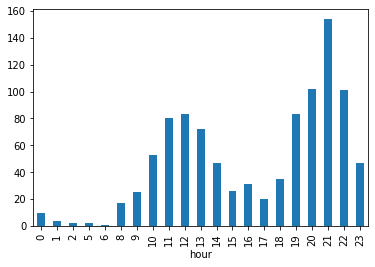

In [39]:
def to_hour(val):
    return val.hour

df['hour'] = df['date_time'].apply(to_hour)
df[df['user']=='Varun.Vardhaman'].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

# hey we chated more during 11pm to 12pm 😂 

#  
#  
#   
